# Expanding on Modeling with Random Variables

When modeling the Guesser, I made the decision to represent the keywords as random variables. This decision may seem a bit contrived because the Guesser only has one keyword. It is in the case of the Intercepter where this decision becomes more clear. The Intercepter does not know what their opponent's keywords are, but they know each of the opponent's keywords is *a* word. Therefore, the Intercepter may find utility in thinking of each keyword as having a certain probability of being any possible word.

Furthermore, when an Intercepter learns about random variables through clues, it's impression of each opponent keyword (the distribution it has for each random variable) may change. We may realize that if our Encryptor is naive and always gives revealing clues, the Interceptor's representation approaches the Guesser's in the limit as rounds continue!

Therefore, if we can appropriately modify the Interceptor's distribution for each random variable, we may use the same guessing algorithm for it to make guesses!

Interestingly, this evokes notions of entropy and information. We may be able to quantify how many bits of information a clue gave the Intercepter by comparing the entropy of its random variables before and after the round. The difference in entropy should correspond to the gained information.

As an Encryptor, we might recognize that our clues are giving the opponent Intercepter information, and give a bad clue to increase the entropy of the opponent Intercepter's random variables. A good Encryption strategy might be to keep track of how much entropy you expect the Intercepter has to deal with, and to present a misleading or revealing clue accordingly.

## Initial Distributions

If our Intercepter is well-versed in Decrypto, it may recognize that there is an almost equal probability of the opponent's keywords being each of the official keywords. That feels a bit like cheating, though; I usually don't know the official keywords when I play. So, our Intercepter may guess less omnipotently that it may be any word. As we have seen, it may make sense to only include nouns, but we may consider that later.

It may also make sense to scale according to frequency. That is, extremely rare words are probably less likely to be a keyword than more common words. We may employ Zipf's law to scale this effectively.

In [38]:
import numpy as np
import decryptogame as dg
import decryptoai.players.unsupervised.numpy_guesser as npg

ALL_WORDS = dg.official_words.english.words[:20]
ALL_WORD_INDEX = {word: ALL_WORDS.index(word) for word in ALL_WORDS}

# shape-preserving normalization

def normalized(log_probabilities: np.array) -> np.array:
    log_cumulative_density = npg.log_expected_probability(lambda i: np.NZERO, log_probabilities, np.zeros(len(log_probabilities))) 
    log_normalization_factor = -log_cumulative_density # log(1) - ...
    return log_probabilities + log_normalization_factor

# initial distribution strategies

def equal_initial_distribution(word_index):
    log_probabilities = normalized(np.zeros(len(word_index)) - np.log(len(word_index)))
    keyword_indices = np.arange(len(word_index))
    return npg.NumpyRandomVariable(log_probabilities, keyword_indices)

def zipf_initial_distribution(word_index):
    log_probabilities = normalized(-np.log(np.arange(1, len(word_index) + 1))) # log(1) - ...
    keyword_indices = np.arange(len(word_index))
    return npg.NumpyRandomVariable(log_probabilities, keyword_indices)




sum of eq probabilities: 1.0000000000000002
sum of zipf probabilities: 0.9999999999999999


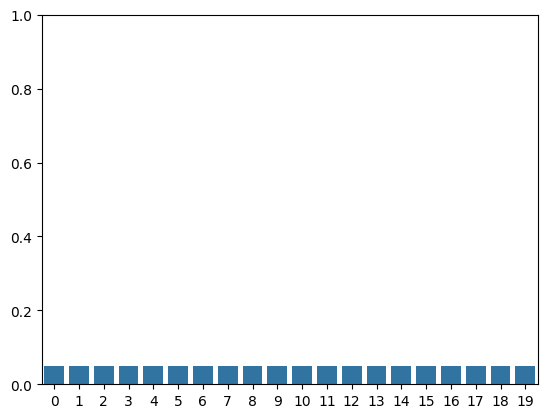

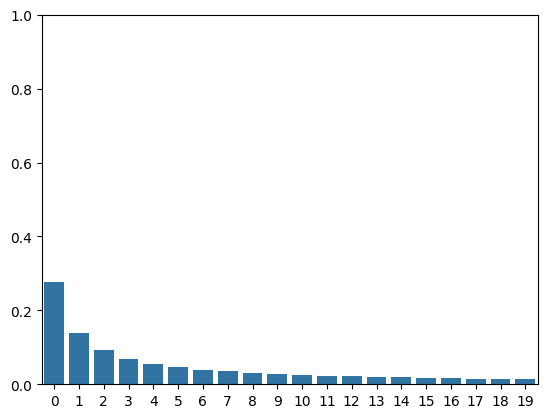

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_random_var(random_var: npg.NumpyRandomVariable, ax: plt.Axes):
    data = dict(zip(random_var.keyword_indices, np.exp(random_var.log_probabilities)))
    sns.barplot(data, ax=ax).set(ylim=(0, 1))

eq = equal_initial_distribution(ALL_WORD_INDEX)
_, ax = plt.subplots()
plot_random_var(eq, ax)
print(f"sum of eq probabilities: {np.sum(np.exp(eq.log_probabilities))}")

zipf = zipf_initial_distribution(ALL_WORD_INDEX)
_, ax = plt.subplots()
plot_random_var(zipf, ax)
print(f"sum of zipf probabilities: {np.sum(np.exp(zipf.log_probabilities))}")

## Updating Distributions

How should our Intercepter update it's internal representation of each distribution upon learning new clues? This is key to how it will improve its guesses over time.

An astute Intercepter may recognize that an astute opposing Encryptor may be misleading at times, and change its distribution-updating strategy accordingly (man this is getting meta). We will ignore this for now, and come up with strategies that assume clues are "good".

A general update strategy may look like multiplying probabilities elementwise, and renormalizing. That is, an Intercepter will multiply each current keyword probability by the likelihood that the clue was for the keyword. Then, it will scale the distribution by a constant factor so that it still adds to 1. The difference in strategies will reside in how the likelihood that the clue was for each keyword is derived.

Let's make up a fake heuristic just to see if we can get the Intercepter to update it's representation well.

In [40]:
from functools import partial
# convenience initializer

def intercepter_random_variables(word_index, initial_distribution_func=equal_initial_distribution, num_vars=4):
    return [initial_distribution_func(word_index) for _ in range(num_vars)]


# optimistic update strat

def updated_random_vars(clue_and_keyword_to_log_probability_func, random_vars: list[npg.NumpyRandomVariable], clue_indices: np.ndarray, correct_code: np.ndarray, probability_reshape=lambda x: x):
    var_log_probabilities = np.array([random_var.log_probabilities for random_var in random_vars])
    var_keyword_indices = np.array([random_var.keyword_indices for random_var in random_vars])
    keyword_to_log_prob = partial(clue_and_keyword_to_log_probability_func, clue_indices)
    log_association_probabilities = keyword_to_log_prob(var_keyword_indices[correct_code])
    reshaped_log_association_probabilities = probability_reshape(log_association_probabilities)
    var_log_probabilities[correct_code] += reshaped_log_association_probabilities
    return [npg.NumpyRandomVariable(normalized(log_probabilities), keyword_indices) for log_probabilities, keyword_indices in zip(var_log_probabilities, var_keyword_indices)]


In [41]:
def naive_clue_and_keyword_log_prob(clue_index, keyword_index):
    return np.where(keyword_index == np.expand_dims(clue_index, axis=-1), np.log(0.9), np.log(0.05))

hidden_kw_card = (ALL_WORDS[7], ALL_WORDS[3], ALL_WORDS[11], ALL_WORDS[1])
hidden_code = (2, 1, 0)

naive_clue = tuple(hidden_kw_card[i] for i in hidden_code)

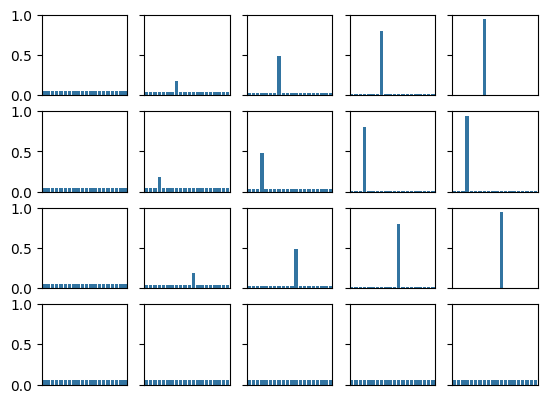

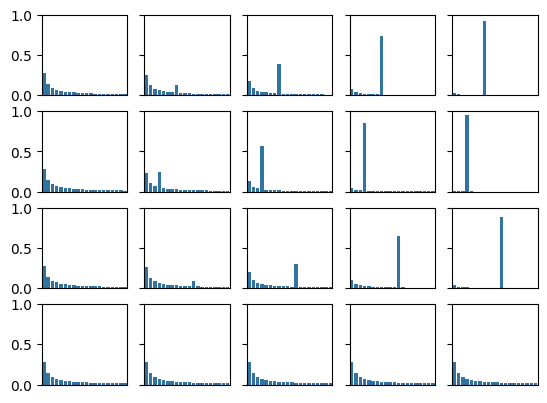

In [47]:


def plot_random_vars(random_vars, axs, round=0):
    for vi, random_var in enumerate(random_vars):
        axs[vi, round].get_xaxis().set_visible(False)
        plot_random_var(random_var, axs[vi, round])

num_vars, num_rounds = 4, 5

for initial_distribution in [equal_initial_distribution, zipf_initial_distribution]:
    random_vars = intercepter_random_variables(ALL_WORD_INDEX, initial_distribution)
    _, axs = plt.subplots(num_vars, num_rounds, sharey=True)
    plot_random_vars(random_vars, axs)
    for round in range(1, num_rounds):
        clue_indices = npg.np_clues(naive_clue, ALL_WORD_INDEX)
        random_vars = updated_random_vars(naive_clue_and_keyword_log_prob, random_vars, clue_indices, np.array(hidden_code), probability_reshape=lambda x: 0.5 * x)
        plot_random_vars(random_vars, axs, round)


We see the intercepter accumulates likelihood around the hidden true values as rounds progress!